# Programming exercise 3: Multi-class classification and neural networks
Here are my solutions for this exercise on multi-class classification and neural networks. Jupyter notebook template modified from: https://github.com/dibgerge/ml-coursera-python-assignments.

In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt

## 1 Multi-class classification

There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.
$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:- \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set.

### 1.1 Read `.mat` file

**Reference**: https://stackoverflow.com/questions/874461/read-mat-files-in-python

In [14]:
file = sio.loadmat('ex3data1.mat') # Read data using scipy.io
X = file['X'] # Save X array
X = np.column_stack((np.ones(X.shape[0]), X)) # Add bias unit

y = file['y'].reshape((X.shape[0], )) # Save y array
# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

print (f'X has:\n\t{X.shape[0]} training examples\n\t{X.shape[1]} units')
print (f'y has:\n\t{y.shape[0]} training examples\n\t{np.unique(y)} unique outputs')

X has:
	5000 training examples
	401 units
y has:
	5000 training examples
	[0 1 2 3 4 5 6 7 8 9] unique outputs


### 1.2 Visualizing the data

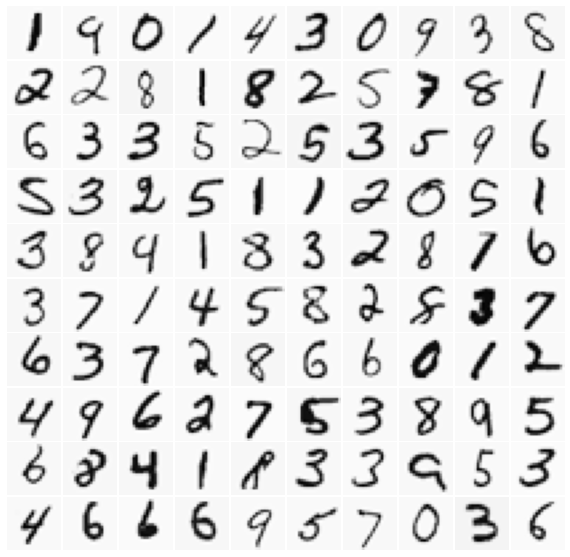

In [19]:
# Randomly select 100 data points to display
X_vis = file['X']
m, n = X_vis.shape
rand_indices = np.random.choice(m, 100, replace=False)
selection = X_vis[rand_indices, :]

displayData(selection)

In [20]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data in X in a grid.
    """
    
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None] # Promote to 2D array
    else:
        raise IndexError('Input X should be 1 or 2 dimensions')
        
    
    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width
    
    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))
    
    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)
    
    ax_array = [ax_array] if m ==1 else ax_array.ravel()
    
    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', 
                  extent=[0, 1, 0, 1])
        ax.axis('off')

### 1.3 Vectorizing logistic regression

I will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, I will need to train 10 separate logistic regression classifiers. In this section, I will implement a vectorized version of logistic regression.

To test your vectorized logistic regression, the following custom data will be use (as defined in the following cell).

In [21]:
# Test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# Test values for the inputs
X_t = np.concatenate([np.ones((5, 1)),
                      np.arange(1, 16).reshape(5, 3, order='F')/10.0],
                      axis=1)

# Test values for the labels
y_t = np.array([1, 0, 1, 0, 1])

# Test value for the regularization parameter
lambda_t = 3 

#### 1.3.1 Vectorizing the cost function and gradient descent

For regularized logistic regression, the cost function is defined as
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_\theta\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_\theta \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note that I should not be regularizing $\theta_0$ which is used for the bias term. Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as
$$ \begin{align*} \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \text{for } j = 0 \\ \frac{\partial J(\theta)}{\partial \theta_0} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j \text{for } j \ge 1 \end{align*} $$

The code in `lrCostFunction` accounts for regularization.

In [22]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Computes the cost of using theta as the parameter for regularized
    logistic regression and the gradient of the cost w.r.t. to the parameters.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept.  
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (including intercept).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
        
    """
    
    # Initialize some useful variables
    m = X.shape[0]
    
    # Convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)

    # Define h_theta(x^(i))
    sigmoid = 1 / (1 + np.exp(-X.dot(theta)))
    # print(sigmoid.shape, y.shape)
    
    # Cost function
    reg = (lambda_ / (2 * m)) * theta[1:].T.dot(theta[1:]) # Regularization
    J = (1 / m) * (-y.dot(np.log(sigmoid)) - (1 - y).dot(np.log(1 - sigmoid))) + reg
    
    # Gradient descent
    grad = theta
    reg_grad = (lambda_ / m) * theta
    grad = (1 / m) * (X.T.dot((sigmoid - y)))
    grad[1:] += reg_grad[1:]
    
    return J, grad

Testing `lrCostFunction` with test values:

In [23]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


### 1.4 One-vs-all classification
The following code is my implementation of one-vs-all classification by training multiple regularized logistic regression classifiers. `.optimize.minimize` function will be used to perform gradient descent.

In [6]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n + 1). m is the number of 
        data points, and n is the number of features. 
    
    y : array_like
        The data labels. A vector of shape (m, ).
    
    num_labels : int
        Number of possible labels.
    
    lambda_ : float
        The logistic regularization parameter.
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    """
        
    # Initialize useful variables
    m, n = X.shape
    
    # Return all thetas for all labels in the dataset
    all_thetas = np.zeros((num_labels, n))
    
    # Set options for optimize.minimize
    options = {'maxiter': 100}
    
    for i in range(num_labels):
        initial_theta = np.zeros(n)
        y_temp = (y == i).astype(int) # Logical array for y (one-vs-all)
        
        result = optimize.minimize(
                                    lrCostFunction,
                                    initial_theta,
                                    (X, y_temp, lambda_),
                                    jac=True,
                                    method='TNC',
                                    options=options)
        all_thetas[i] = result.x
    
    return all_thetas

The following cell will use your implementation to train a multi-class classifier.

In [7]:
lambda_ = 0.1
num_labels = len(np.unique(y)) # Initialize number of labels
all_theta = oneVsAll(X, y, num_labels, lambda_)

#### 1.4.1 One-vs-all prediction

`predictOneVsAll` will be used to test the predictions.

In [8]:
def predictOneVsAll(all_theta, X):
    
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    
    pred_temp = np.zeros((num_labels, m))
    
    for i in range(num_labels):
        theta = all_theta[i]
        prediction = 1 / (1 + np.exp(-X.dot(theta)))
        pred_temp[i] = prediction
    
    pred = np.argmax(pred_temp.T, axis=1)
    
    return pred

In [12]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 96.38%


## 2 Neural networks

Here is my implementation of a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. On the other hand, logistic regression cannot form more complex hypotheses as it is only a linear classifier (You could add more features - such as polynomial features - to logistic regression, but that can be very expensive to train).

In [26]:
# Training data stored in arrays X, y
data = sio.loadmat('ex3data1.mat')
X, y = data['X'], data['y'].reshape(y.size,)

# Change 10 to 0
y[y==10] = 0

# Number of examples in the dataset
m = y.size

# Randomly permute examples. For visualizing one image at a time.
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
selection = X[rand_indices, :]

# displayData(selection)

### 2.1 Model representation
The neural network model can be demonstrated in the following figure:

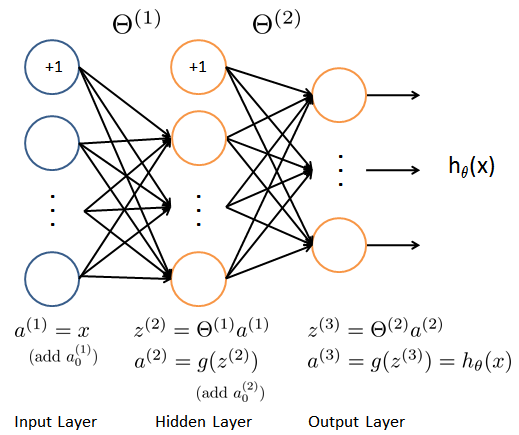

In [27]:
# Setup the parameters for this model
input_layer_size = 400 # 20x20 input images of digits
hidden_layer_size = 25 # 25 hidden units
num_labels = 10        # 10 labels from 0 to 9

# Load .mat file which returns a dictionary
weights = sio.loadmat('ex3weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']
print (f'Theta 1 has size: {theta1.shape}')
print (f'Theta 2 has size: {theta2.shape}')

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
theta2 = np.roll(theta2, 1, axis=0)

Theta 1 has size: (25, 401)
Theta 2 has size: (10, 26)


In [28]:
def sigmoid(X, theta):
    
    h = X.dot(theta.T)
    g = (1 / (1 + np.exp(-h)))
    
    return g

In [29]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.
    
    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)
    
    Theta2: array_like
        Weights for the second layer in the neural network. 
        It has shape (output layer size x 2nd hidden layer size)
    
    X : array_like
        The image inputs having shape (number of examples x image dimensions).
    
    Return 
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.
    """
    
    # Make sure that the input has two dimensions
    if X.ndim == 1:
        X = X[None] # promote to two dimensions
    
    # Initialize variables
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    
    # Return the following variables
    p = np.zeros(X.shape[0])
    
    # Add bias unit for X
    X = np.concatenate([np.ones((m,1)), X], axis=1)
    
    # Activation layer 2 calculation
    a2 = sigmoid(X, theta1)
    
    # Activation layer 3 calculation (output layer)
    a2 = np.concatenate([np.ones((m,1)), a2], axis=1)
    a3 = sigmoid(a2, theta2)
    
    # Determine prediction using maximum probability
    p = np.argmax(a3, axis=1)
    
    return p

In [30]:
pred = predict(theta1, theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


The following code displays the images one at a time.

Neural network prediction: 5


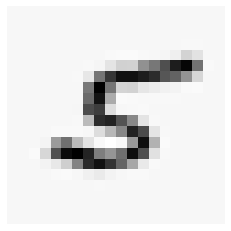

In [34]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    pred = predict(theta1, theta2, X[i: ])
    print (f'Neural network prediction: {pred[0]}')
else:
    print(f'No more images to display')